In [1]:
# nsmc 텍스트 토큰나이징 한 pickle 데이터 불러오기
import pickle
with open('train_text.pk', 'rb') as f:
    train = pickle.load(f)
with open('test_text.pk', 'rb') as f:
    test = pickle.load(f)

In [2]:
len(train), len(test)

(146124, 48760)

In [3]:
# import
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os

In [4]:
# conda install tensorflow-gpu
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10173937678158964349]

In [5]:
# 파라미터
max_words = 35000
max_len = 50
batch_size=128
epochs = 30

In [6]:
# 데이터 전처리
# 토크나이징, 패딩(제로패딩)
import numpy as np

# 문서만 추출
train_x = [doc for doc, _ in train]

# 토크나이징
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_x)

# 변환(LSTM모델의 입력값을 넣기 위해)
x_train = tokenizer.texts_to_sequences(train_x)
y_train = np.array([int(label) for _, label in train])

x_test = tokenizer.texts_to_sequences([doc for doc, _ in test])
y_test = np.array([int(label) for _, label in test])

# 길이를 동일하게 맞추기
x_train = pad_sequences(x_train, maxlen=max_len, padding='pre')
x_test = pad_sequences(x_test, maxlen=max_len, padding='pre')

# 학습가능한 형태로 변환
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [7]:
train_ds

<BatchDataset shapes: ((None, 50), (None,)), types: (tf.int32, tf.int32)>

In [8]:
# 모델 구현
# 클래스로 구현하는 방법
class MyLSTM(tf.keras.Model):
    # 생성자
    def __init__(self):
        # 부모클래스의 생성자 호출
        super().__init__()
        self.emb = Embedding(max_words, 100)
        self.lstm = LSTM(128, dropout=0.2, recurrent_dropout=0.2)
        self.dense = Dense(1, activation='sigmoid')
    
    def call(self, x):
        x = self.emb(x)
        x = self.lstm(x)
        x = self.dense(x)
        return x

In [9]:
# 모델객체 선언
model = MyLSTM()

In [10]:
# 모델설정
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [11]:
MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
  os.mkdir(MODEL_SAVE_FOLDER_PATH)
model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'


In [12]:
# Early Stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, verbose=1)
# ModelCheckpoint
mc = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

In [13]:
# 학습
history = model.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size, callbacks=[es, mc])

Epoch 1/30
1142/1142 [==============================] - 151s 130ms/step - loss: 0.4685 - acc: 0.7641 - val_loss: 0.3938 - val_acc: 0.8185

Epoch 00001: val_loss improved from inf to 0.39379, saving model to ./model\01-0.3938.hdf5
Epoch 2/30
1142/1142 [==============================] - 137s 120ms/step - loss: 0.3473 - acc: 0.8462 - val_loss: 0.3995 - val_acc: 0.8185

Epoch 00002: val_loss did not improve from 0.39379
Epoch 3/30
1142/1142 [==============================] - 136s 119ms/step - loss: 0.2989 - acc: 0.8699 - val_loss: 0.4244 - val_acc: 0.8137

Epoch 00003: val_loss did not improve from 0.39379
Epoch 4/30
1142/1142 [==============================] - 140s 122ms/step - loss: 0.2515 - acc: 0.8922 - val_loss: 0.4665 - val_acc: 0.8063

Epoch 00004: val_loss did not improve from 0.39379
Epoch 5/30
1142/1142 [==============================] - 139s 122ms/step - loss: 0.2142 - acc: 0.9091 - val_loss: 0.5306 - val_acc: 0.7988

Epoch 00005: val_loss did not improve from 0.39379
Epoch 6/30

model.evaluate(x_test, y_test)

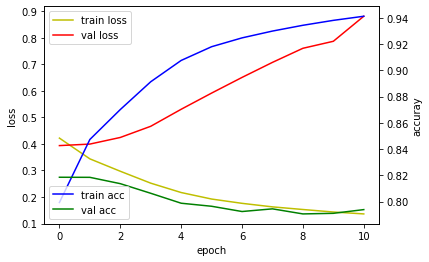

<Figure size 1152x1008 with 0 Axes>

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.figure(figsize=(16,14))
plt.show()

In [28]:
# 모델 저장
model.save('ncms_lstm')

INFO:tensorflow:Assets written to: ncms_lstm\assets
